Источник: https://habr.com/ru/companies/ruvds/articles/689072/

Colab: https://colab.research.google.com/drive/1Bcueb7NFAlWsFPF1NBEYDBqE6nvBqrN0

Видео: https://www.youtube.com/watch?v=z7QH-WWHmfE

Тут детальное объяснение с математическим обоснованием: https://lilianweng.github.io/posts/2021-07-11-diffusion-models/




In [ ]:
!pip install datasets &>> install.log

In [ ]:
from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F
import os
from tqdm.notebook import tqdm
import torch
import numpy as np

In [ ]:
def img_to_tensor(im):
    return torch.tensor(np.array(im.convert('RGB'))/255).permute(2, 0, 1).unsqueeze(0) * 2 - 1

def tensor_to_image(t):
    return Image.fromarray(np.array(((t.squeeze().permute(1, 2, 0)+1)/2).clip(0, 1)*255).astype(np.uint8))

def gather(consts: torch.Tensor, t: torch.Tensor):
    """
    метод gather выбирает из тензора consts значения с индексом,
    указанным в тензоре t. Ось поиска задается первым аргументом метода gather.
    Например, -1 это последняя ось тензора consts. Примеры работы функции ниже
    """
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

In [ ]:
consts =torch.randn((2 , 3 , 4))
t = torch.ones(2, 3, 4, dtype=torch.int64)

In [ ]:
consts

tensor([[[-0.2653, -0.7271,  0.5495,  0.9286],
         [ 1.3153, -0.8837,  1.1757, -1.0830],
         [ 0.1038,  1.7003, -0.4052,  0.0125]],

        [[-0.5832,  0.2050, -0.8723,  0.5500],
         [-2.0585, -0.3433, -0.2061, -0.6346],
         [ 1.1446,  0.3613,  0.1619, -0.7441]]])

In [ ]:
consts.gather(-1, t)

tensor([[[-0.7271, -0.7271, -0.7271, -0.7271],
         [-0.8837, -0.8837, -0.8837, -0.8837],
         [ 1.7003,  1.7003,  1.7003,  1.7003]],

        [[ 0.2050,  0.2050,  0.2050,  0.2050],
         [-0.3433, -0.3433, -0.3433, -0.3433],
         [ 0.3613,  0.3613,  0.3613,  0.3613]]])

In [ ]:
consts.gather(0, t)

tensor([[[-0.5832,  0.2050, -0.8723,  0.5500],
         [-2.0585, -0.3433, -0.2061, -0.6346],
         [ 1.1446,  0.3613,  0.1619, -0.7441]],

        [[-0.5832,  0.2050, -0.8723,  0.5500],
         [-2.0585, -0.3433, -0.2061, -0.6346],
         [ 1.1446,  0.3613,  0.1619, -0.7441]]])

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:332: UserWarning: Downcasting array dtype uint8 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

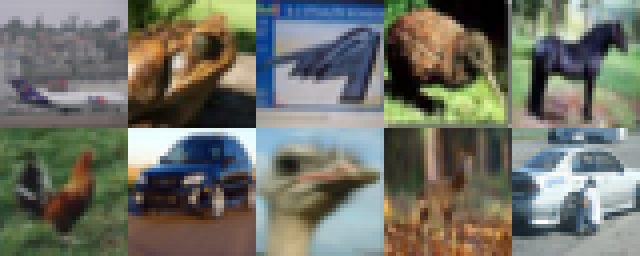

In [ ]:
# Скачать и загрузить набор данных
cifar10 = load_dataset('cifar10')

image = Image.new('RGB', size=(32*5, 32*2))
for i in range(10):
  im = cifar10['train'][i]['img']
  image.paste(im, ( (i%5)*32, (i//5)*32 ))
image.resize((32*5*4, 32*2*4), Image.NEAREST)

### Процесс преобразования изображений в белый шум

Для создания набора шумных изображений нам потребуется наложить Гаусовский шум на наш набор данных. Мы устанавливаем «график отклонений», он указывает, сколько шума мы хотим добавить на одном шаге.

Всё просто. Мы смешиваем $x_{t−1}$ с Гаусовским шумом, определяемым $βt$
Ключевая идея в том, что после нескольких шагов шум будет складываться.


$$ q(x_{t}|x_{t-1}) = N(x_{t};\sqrt{1 - \beta_{t}}x_{t-1}, \beta_{t}I) \hspace{0.5cm} q(x_{1:T}|x_{0}) =  \prod_{t=1}^{T} q(x_{t}|x_{t-1}) $$

, где:

$x_{t}$ - изображение на текущем шаге

$x_{t-1}$ -  изображение на предыдущем шаге

$\beta_{t}$ - некая константа, дисперсия

$I$ - диагональная матрица ковариации.

$N$ - нормальное распределение случайной величины $x_{t}$

$\sqrt{1 - \beta_{t}}x_{t-1}$ - среднее значение

$\beta_{t}I$ - дисперсия


Дана выборка точек из реального распределения $x_{0} \sim q(x)$. Давайте определим процесс добавления шума к изображениям. Мы на каждом шаге $T$ добавляем небольшое количество Гауссовского шума, создавая последовательность все более зашумленных изображений $x_{1}, ..., x_{T}$.

Сила изменений на каждом шаге задается переменной отклонения ${ \beta_{t} \in (0, 1)}_{t=1}^{T}$

Изображения в выборке данных $x_{0}$ постепенно искажаются белым шумом по мере увеличения шага $t$. В конце концов, когда $T \rightarrow \infty$, $x_{T}$ станет эквивалетно изотропному распределению Гаусса.$

<img src="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png"/>



Процесс:
$$ q(x_{t}|x_{t-1}) = N(x_{t};\sqrt{1 - \beta_{t}}x_{t-1}, \beta_{t}I)$$

Мы можем также рассписать следующим образом:

$$x_{t} = \sqrt{\alpha_{t}}x_{t-1} + \sqrt{1 - \alpha_{t}} \epsilon_{t} $$

, где

$\alpha_{t}= 1 - \beta$

$\epsilon_{t} \sim N(0, I)$ - шум, который генерируется из нормального распределения

$\sqrt{1 - \alpha_{t}}$ - регулирует силу шума

In [ ]:
n_steps = 100
# генерирует вектор с числовой последовательность от и до, и шагом
beta = torch.linspace(0.0001, 0.04, n_steps)

def q_xt_xtminus1(xtm1, t):
  mean = gather(1. - beta, t) ** 0.5 * xtm1 # √(1−βt)*xtm1
  var = gather(beta, t) # βt
  eps = torch.randn_like(xtm1) # Шум в форме xtm1
  return mean + (var ** 0.5) * eps

# Показать на разных этапах
ims = []
start_im = cifar10['train'][3]['img']
x = img_to_tensor(start_im).squeeze()
for t in range(n_steps):

  # Сохранение изображения каждые 20 шагов, чтобы показать прогресс
  if t%20 == 0:
    ims.append(tensor_to_image(x))

  # Вычислить Xt с учётом Xt-1 (т.е. x из предыдущей итерации)
  t = torch.tensor(t, dtype=torch.long) # t как тензор
  x = q_xt_xtminus1(x, t) # Изменение x, используя нашу функцию выше

In [ ]:
t = torch.tensor(10, dtype=torch.long)
t

tensor(10)

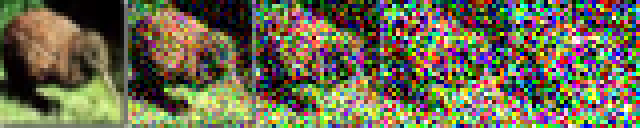

In [ ]:
# Отображение изображений
image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Приятным свойством описанного выше процесса является то, что мы можем сделать выборку на любом произвольном временном шаге, используя прием репараметризации. Пусть $\alpha_{t} = 1 - \beta_{t}$, тогда $\bar{\alpha_{t}} = \prod_{i=1}^{t}\alpha_{i}$

Давайте попробуем использовать приём репараметризации, который позволяет нам сразу получить $x_{t}$ любого $x_{0}$

$$ x_{t} = \sqrt{\bar{a_{t}}}x_{0} + \sqrt{1- \bar{a_{t}}} \epsilon $$

, где

$\epsilon \sim N(0, I)$

$\bar{\alpha_{t}} = \prod_{i=1}^{t}\alpha_{i}$

In [ ]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_xt_x0(x0, t):
  mean = gather(alpha_bar, t) ** 0.5 * x0 # теперь alpha_bar
  var = 1-gather(alpha_bar, t) # (1-alpha_bar)
  eps = torch.randn_like(x0)
  return mean + (var ** 0.5) * eps

# Показать на разных этапах
ims = []
start_im = cifar10['train'][3]['img']
x0 = img_to_tensor(start_im).squeeze()

# Заметьте, что теперь нам не требуется использовать *for t in range*
for t in [0, 20, 40, 60, 80]:
  x = q_xt_x0(x0, torch.tensor(t, dtype=torch.long))
  ims.append(tensor_to_image(x))

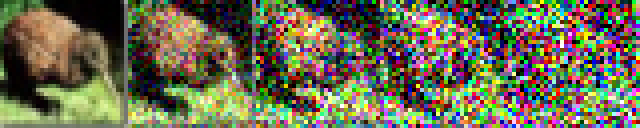

In [ ]:
image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

### Шумоподавление U-net

Единственное требование к нашей архитектуре Шумоподавления — чтобы её вход и выход были одинаковыми размерами. Именно поэтому неудивительно то, что модель диффузии изображения часто реализуется с архитектурами, подобными U-Net.

U-NET представляет собой архитектуру преобразования изображения в изображение. Чаще всего её используют для сегментации биомедицинских изображений, но и нам пригодилась.

<img src="https://hsto.org/getpro/habr/post_images/622/e7a/b8e/622e7ab8e6da6a5d581407b1557df2e5.png"/>

Архитектура передаёт информацию с ранних уровней с высоким разрешением — в более поздние уровни. «Ярлык» позволяет сети использовать подробные функции исходного изображения, а также захватывать более высокоуровневую семантику из глубоких слоёв.

Диффузионные нейросети используют архитектуру U-NETс одним дополнением: TimeEmbedding
TimeEmbedding кодирует временной шаг (t) и позволяет модели использовать это в качестве информации для кондиционирования, передавая её в середине сети.

Если вы копируете код по ходу статьи, скопируйте код U-NET отсюда. (Но в любом случае в конце будет ссылка на colab со всем кодом из статьи)



In [ ]:
#@title Unet

import math
from typing import Optional, Tuple, Union, List

import torch
from torch import nn

# Необычная функция активации
class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)

# Time Embedding
class TimeEmbedding(nn.Module):

    def __init__(self, n_channels: int):
        super().__init__()
        self.n_channels = n_channels
        # Первый линейный слой
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Активация
        self.act = Swish()
        # Второй линейный слой
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        return emb

class ResidualBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, n_groups: int = 32):
        super().__init__()
        # Групповая нормализация и первый слой свертки
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        self.time_emb = nn.Linear(time_channels, out_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # Первый слой сверткиr
        h = self.conv1(self.act1(self.norm1(x)))
        # Добавление time embeddings
        h += self.time_emb(t)[:, :, None, None]
        # Второй слой свертки
        h = self.conv2(self.act2(self.norm2(h)))
        return h + self.shortcut(x)

# attention
class AttentionBlock(nn.Module):

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Слой нормализации
        self.norm = nn.GroupNorm(n_groups, n_channels)
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Линейный слой для окончательного преобразования
        self.output = nn.Linear(n_heads * d_k, n_channels)
        self.scale = d_k ** -0.5
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        _ = t

        batch_size, n_channels, height, width = x.shape

        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)

        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)

        q, k, v = torch.chunk(qkv, 3, dim=-1)

        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        attn = attn.softmax(dim=1)
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        res = self.output(res)


        res += x


        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        return res


class DownBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)

# The core class definition (aka the important bit)
class UNet(nn.Module):

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
                 n_blocks: int = 2):
        super().__init__()


        n_resolutions = len(ch_mults)


        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))


        self.time_emb = TimeEmbedding(n_channels * 4)


        down = []

        out_channels = in_channels = n_channels

        for i in range(n_resolutions):

            out_channels = in_channels * ch_mults[i]

            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels

            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))


        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Вторая половина U-Net - увеличение разрешения
        up = []

        in_channels = out_channels

        for i in reversed(range(n_resolutions)):

            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))

            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels

            if i > 0:
                up.append(Upsample(in_channels))


        self.up = nn.ModuleList(up)


        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):

        # Получить time-step embeddings
        t = self.time_emb(t)

        x = self.image_proj(x)

        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        x = self.middle(x, t)

        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Получить пропущенное соединение из первой половины U-Net и объединить
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                x = m(x, t)

        # Окончательная нормализация и свертка
        return self.final(self.act(self.norm(x)))

### Обучение

Теперь мы должны научить модель нам нужно обучить её предсказывать шум с учётом $x_{t}$ и $t$. Но почему мы возимся с этим, а не генерируем шумное изображение напрямую?

В основном просто из-за удобства. Шум хорошо масштабируется со средним значением, равным нулю, и это хорошо подходит для моделирования с помощью нейронной сети. Настроим нашу функцию q_xt_x0 так, чтобы она возвращала как изображение с шумом ($x_{t}$), так и сам шум, который будет целью, которую пытается создать наша модель.

In [ ]:
x = torch.randn(10, 3, 32, 32)
t = torch.tensor([50.], dtype=torch.long)
unet = UNet()
model_output = unet(x, t)
model_output.shape

# Создайте модель
unet = UNet(n_channels=32).cuda()

# Настройка параметров
n_steps = 300
beta = torch.linspace(0.0001, 0.04, n_steps).cuda()
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# возвращаем шум
def q_xt_x0(x0, t):
  mean = gather(alpha_bar, t) ** 0.5 * x0
  var = 1-gather(alpha_bar, t)
  eps = torch.randn_like(x0).to(x0.device)
  return mean + (var ** 0.5) * eps, eps # также возвращает шум

# Тренировочные параметры
batch_size = 128
lr = 3e-4 # Скорость обучение, это значение я называю константой Карпати

losses = [] # Сохранение потери для построения графика

dataset = cifar10['train']
optim = torch.optim.AdamW(unet.parameters(), lr=lr) # Оптимизатор

In [ ]:
for i in tqdm(range(0, len(dataset)-batch_size, batch_size)): # Просмотр набора данных
    ims = [dataset[idx]['img'] for idx in range(i,i+batch_size)]
    tims = [img_to_tensor(im).cuda() for im in ims] # Преобразование в тензоры
    x0 = torch.cat(tims)
    t = torch.randint(0, n_steps, (batch_size,), dtype=torch.long).cuda()
    xt, noise = q_xt_x0(x0, t)
    pred_noise = unet(xt.float(), t)
    loss = F.mse_loss(noise.float(), pred_noise)
    losses.append(loss.item())
    optim.zero_grad()
    loss.backward()
    optim.step()

  0%|          | 0/390 [00:00<?, ?it/s]

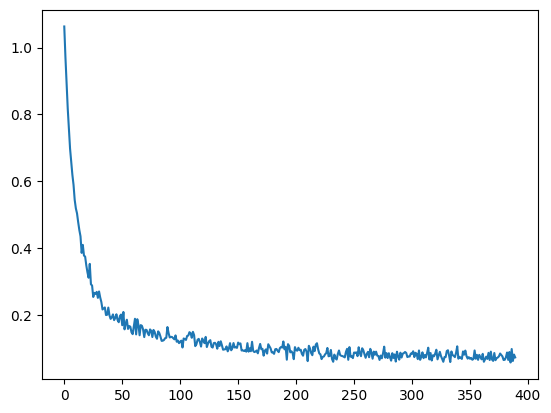

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)

### Шумоподавление

Теперь нам нужно определить шумоподавление $p_{θ}(x_{t−1}|x_{t})$.

$$ x_{t-1} = \frac{1}{\sqrt{a_{t}}} \biggl(x_{t} - \frac{1-a_{t}}{\sqrt{1 - \bar{a_{t}}}} \epsilon  \biggr) + \tilde{\beta_{t}}z$$

, где

$ z \sim N(0, I)$


$ \tilde{\beta_{t}} = \frac{1 - \bar{a}_{t-1}}{1 - \bar{a}_{t}} \beta_{t}$




Мы используем нашу модель для прогнозирования шума, а затем «отменяем» шаги прямого шума по одному за раз, чтобы перейти от изображения, представляющего собой чистый шум, к изображению, которое (надеюсь) выглядит похоже на реальное изображение&

In [ ]:
def p_xt(xt, noise, t):
  alpha_t = gather(alpha, t)
  alpha_bar_t = gather(alpha_bar, t)
  eps_coef = (1 - alpha_t) / (1 - alpha_bar_t) ** .5
  mean = 1 / (alpha_t ** 0.5) * (xt - eps_coef * noise)
  var = gather(beta, t)
  eps = torch.randn(xt.shape, device=xt.device)
  return mean + (var ** 0.5) * eps

x = torch.randn(1, 3, 32, 32).cuda() # Создадим рандомный шум
ims = []
for i in range(n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = unet(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))
    if i%74 == 0:
      ims.append(tensor_to_image(x.cpu()))

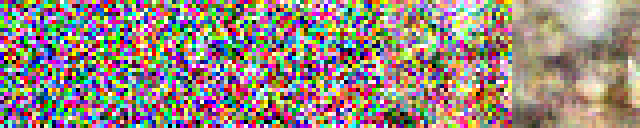

In [ ]:
image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims[:5]):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Мы тренируемся здесь только со 300 шагами шума, и, возможно, модель видит изображения, в которых есть хотя бы небольшая структура, но это далеко не идеально, отчасти из-за маленького размера модели. Если мы начнём с изображения с наполовину зашумлённого, может ли оно исправить его до чего-то похожего на оригинал?

torch.Size([10, 3, 32, 32])


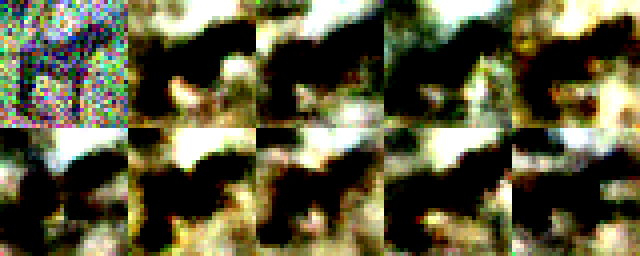

In [ ]:
horse = cifar10['train'][4]['img']
x0 = img_to_tensor(horse)
x = torch.cat([q_xt_x0(x0.cuda(), torch.tensor(50, dtype=torch.long).cuda())[0] for _ in range(10)] )
example_start = q_xt_x0(x0.cuda(), torch.tensor(50, dtype=torch.long).cuda())[0]
print(x.shape)
ims = []
for i in range(50, n_steps):
  t = torch.tensor(n_steps-i-1, dtype=torch.long).cuda()
  with torch.no_grad():
    pred_noise = unet(x.float(), t.unsqueeze(0))
    x = p_xt(x, pred_noise, t.unsqueeze(0))

for i in range(10):
  ims.append(tensor_to_image(x[i].unsqueeze(0).cpu()))

image = Image.new('RGB', size=(32*5, 32*2))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 32*(i//5)))
  if i==0:image.paste(tensor_to_image(example_start.unsqueeze(0).cpu()), ((i%5)*32, 32*(i//5)))
image.resize((32*4*5, 32*4*2), Image.NEAREST)